## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
patience_nums = [10,25]

In [10]:
from keras.callbacks import EarlyStopping
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for patience_num in patience_nums:
    id_ = 'patience_num: '+str(patience_num)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    earlystop = EarlyStopping(monitor="val_acc", 
                              patience=patience_num, 
                              verbose=1
                              )
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    results[id_]= {
        'train_loss' : model.history.history["loss"]
        ,'valid_loss' : model.history.history["val_loss"]
        ,'train_acc' : model.history.history["acc"]
        ,'valid_acc' : model.history.history["val_acc"]
    }

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 28s 563us/step - loss: 2.2159 - acc: 0.2695 - val_loss: 2.0791 - val_acc: 0.3095
Epoch 2/50
50000/50000 [==============================] - 23s 468us/step - loss: 1.7458 - acc: 0.3922 - val_loss: 1.8098 - val_acc: 0.3787
Epoch 3/50
50000/50000 [==============================] - 22s 442us/step - loss: 1.6161 - acc: 0.4372 - val_loss: 1.6587 - val_acc: 0.4198
Epoch 4/50
50000/50000 [==============================] - 22s 438us/step - loss: 1.5421 - acc: 0.4623 - val_loss: 1.6237 - val_acc: 0.4263
Epoch 5/50
50000/50000 [==============================] - 23s 454us/step - loss: 1.4873 - acc: 0.4830 - val_loss: 1.5927 - val_acc: 0.4421
Epoch 6/50
50000/50000 [==============================] - 23s 460us/step - loss: 1.4430 - acc: 0.4991 - val_loss: 1.5602 - val_acc: 0.4465
Epoch 7/50
50000/50000 [==============================] - 23s 459us/step - loss: 1.4041 - acc: 0.5107 - val_loss: 1.

0 patience_num: 10
1 patience_num: 25


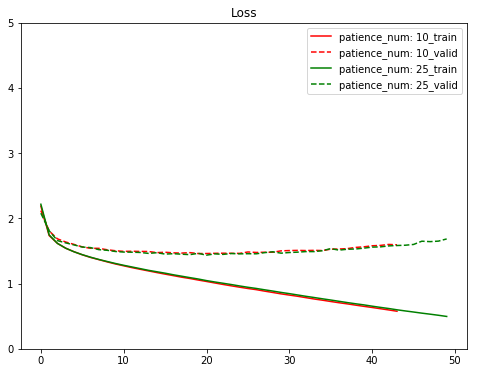

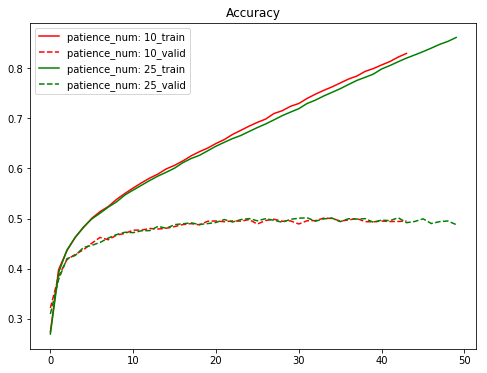

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()